In [55]:
import numpy as np
from cryptocmd import CmcScraper
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import KFold, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import pandas as pd


from sklearn.linear_model import Ridge


In [42]:
coins = ['btc', 'eth', 'aave', 'doge', 'xrp']
coin_names = ['Bitcoin', 'Ethereum', 'Aave', 'Dogecoin', 'XRP']
df_dict = {}
scaled_coins = {}

for coin, name in zip(coins, coin_names):
    scraper = CmcScraper(coin_code=coin, coin_name=name)
    df = scraper.get_dataframe()
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)

    scaler = MinMaxScaler(feature_range=(0, 1))
    columns_to_scale = ['Open', 'Low', 'Close', 'Volume', 'Market Cap', 'High']
    df_scaled = pd.DataFrame(scaler.fit_transform(df[columns_to_scale]), columns=columns_to_scale, index=df.index)
    scaled_coins[name] = df_scaled

In [53]:
results = {}
for coin, df_coin in scaled_coins.items():

    X = df_coin[['Open', 'Low', 'Close', 'Volume', 'Market Cap']].values
    Y = df_coin[['High']].values.astype('float32')

    Y_log = np.log1p(Y)

    scaler = MinMaxScaler(feature_range=(0, 1))
    Y_scaled = scaler.fit_transform(Y_log)

    k_folds = 5

    kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

    train_scores = []
    test_scores = []
    r2_scores_train = []
    r2_scores_test = []

    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        Y_train, Y_test = Y_scaled[train_index], Y_scaled[test_index]

        model = Ridge()
        model.fit(X_train, Y_train)

        train_pred = model.predict(X_train)
        test_pred = model.predict(X_test)

        train_pred_unscaled = np.expm1(scaler.inverse_transform(train_pred))
        test_pred_unscaled = np.expm1(scaler.inverse_transform(test_pred))
        train_y_unscaled = np.expm1(scaler.inverse_transform(Y_train))
        test_y_unscaled = np.expm1(scaler.inverse_transform(Y_test))

        train_score = np.sqrt(mean_squared_error(train_y_unscaled, train_pred_unscaled))
        test_score = np.sqrt(mean_squared_error(test_y_unscaled, test_pred_unscaled))

        train_scores.append(train_score)
        test_scores.append(test_score)

        train_r2 = r2_score(train_y_unscaled, train_pred_unscaled)
        test_r2 = r2_score(test_y_unscaled, test_pred_unscaled)
        r2_scores_train.append(train_r2)
        r2_scores_test.append(test_r2)
        # print(f"{coin}: Train R2: {train_r2:.2f}")
        # print(f" {coin}: Train RMSE: {train_score:.2f}")


    results[coin] = {'avg_rmse_train': np.mean(train_scores), 'avg_rmse_test': np.mean(test_scores), 'avg_r2_train': np.mean(r2_scores_train) ,
                     'avg_r2_test': np.mean(r2_scores_test)}

    print(f"Avg RMSE Train {coin}: {np.mean(train_scores):.2f}")
    print(f"Avg RMSE Test {coin}: {np.mean(test_scores):.2f}")
    print(f"Avg R2 Train {coin}: {np.mean(r2_scores_train):.2f}")
    print(f"Avg R2 Test {coin}: {np.mean(r2_scores_test):.2f}")



df_results = pd.DataFrame(results).T




Avg RMSE Train Bitcoin: 0.02
Avg RMSE Test Bitcoin: 0.02
Avg R2 Train Bitcoin: 0.99
Avg R2 Test Bitcoin: 0.99
Avg RMSE Train Ethereum: 0.02
Avg RMSE Test Ethereum: 0.02
Avg R2 Train Ethereum: 0.99
Avg R2 Test Ethereum: 0.99
Avg RMSE Train Aave: 0.01
Avg RMSE Test Aave: 0.01
Avg R2 Train Aave: 0.99
Avg R2 Test Aave: 0.99
Avg RMSE Train Dogecoin: 0.01
Avg RMSE Test Dogecoin: 0.01
Avg R2 Train Dogecoin: 0.99
Avg R2 Test Dogecoin: 0.99
Avg RMSE Train XRP: 0.01
Avg RMSE Test XRP: 0.01
Avg R2 Train XRP: 0.99
Avg R2 Test XRP: 0.99


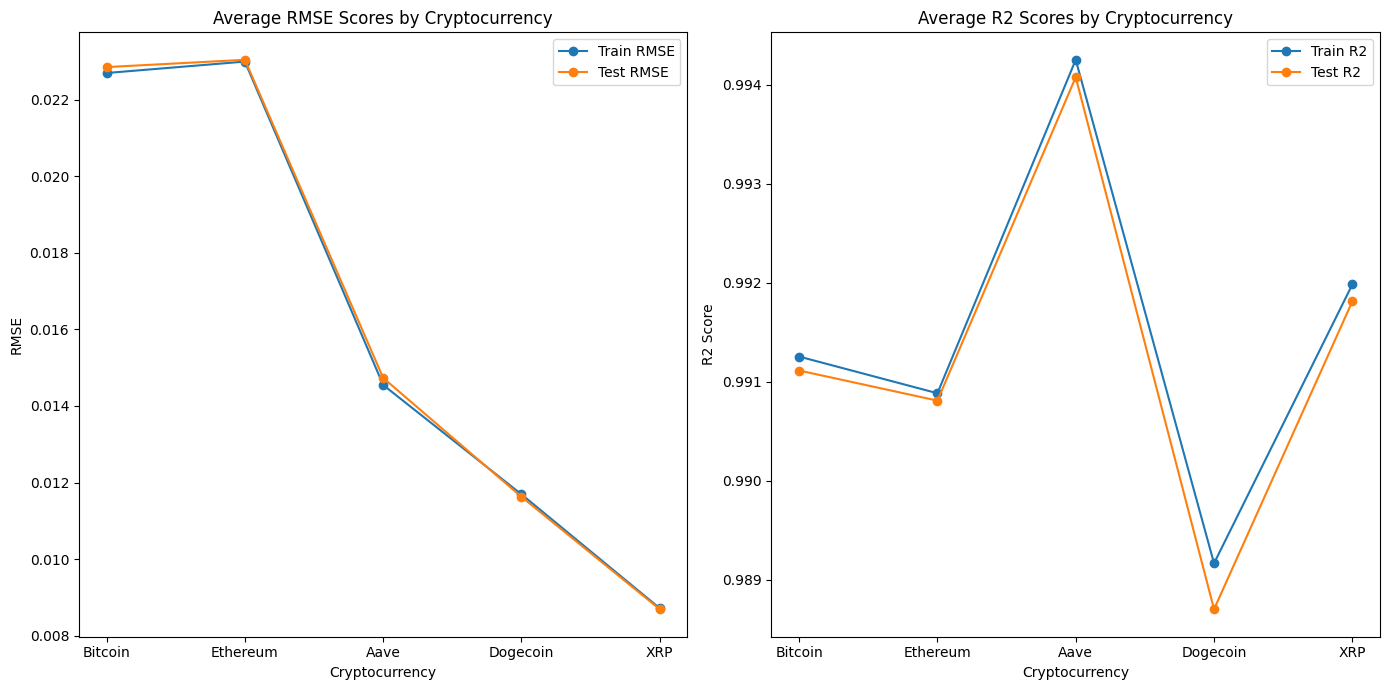

In [54]:
plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
plt.plot(df_results.index, df_results['avg_rmse_train'], label='Train RMSE', marker='o')
plt.plot(df_results.index, df_results['avg_rmse_test'], label='Test RMSE', marker='o')
plt.title('Average RMSE Scores by Cryptocurrency')
plt.ylabel('RMSE')
plt.xlabel('Cryptocurrency')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(df_results.index, df_results['avg_r2_train'], label='Train R2', marker='o')
plt.plot(df_results.index, df_results['avg_r2_test'], label='Test R2', marker='o')
plt.title('Average R2 Scores by Cryptocurrency')
plt.ylabel('R2 Score')
plt.xlabel('Cryptocurrency')
plt.legend()

plt.tight_layout()
plt.show()

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END ...........model__alpha=10, model__solver=sparse_cg; total time=   0.0s
[CV] END ...........model__alpha=10, model__solver=sparse_cg; total time=   0.0s
[CV] END ...........model__alpha=10, model__solver=sparse_cg; total time=   0.0s
[CV] END ................model__alpha=0.1, model__solver=svd; total time=   0.0s
[CV] END .................model__alpha=10, model__solver=sag; total time=   0.0s
[CV] END ...............model__alpha=0.1, model__solver=saga; total time=   0.0s
[CV] END ................model__alpha=0.1, model__solver=svd; total time=   0.0s
[CV] END .........model__alpha=0.01, model__solver=sparse_cg; total time=   0.0s
[CV] END ...............model__alpha=0.1, model__solver=saga; total time=   0.0s
[CV] END .........model__alpha=0.01, model__solver=sparse_cg; total time=   0.0s
[CV] END ...............model__alpha=0.1, model__solver=saga; total time=   0.0s
[CV] END ................model__alpha=0.1, model

/Users/nikhilgudur/code-base/data-270-project/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END ...........model__alpha=10, model__solver=sparse_cg; total time=   0.0s
[CV] END ...........model__alpha=10, model__solver=sparse_cg; total time=   0.0s
[CV] END ...........model__alpha=10, model__solver=sparse_cg; total time=   0.0s
[CV] END ...............model__alpha=0.1, model__solver=saga; total time=   0.0s
[CV] END ...............model__alpha=0.1, model__solver=saga; total time=   0.0s
[CV] END ................model__alpha=0.1, model__solver=svd; total time=   0.0s
[CV] END ................model__alpha=0.1, model__solver=svd; total time=   0.0s
[CV] END ................model__alpha=0.1, model__solver=svd; total time=   0.0s
[CV] END .................model__alpha=10, model__solver=sag; total time=   0.0s
[CV] END ...............model__alpha=0.1, model__solver=saga; total time=   0.0s
[CV] END .................model__alpha=10, model__solver=sag; total time=   0.0s
[CV] END .................model__alpha=10, model

/Users/nikhilgudur/code-base/data-270-project/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ..............model__alpha=0.01, model__solver=saga; total time=   0.1s
Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END ...........model__alpha=10, model__solver=sparse_cg; total time=   0.0s
[CV] END ...........model__alpha=10, model__solver=sparse_cg; total time=   0.0s
[CV] END ...........model__alpha=10, model__solver=sparse_cg; total time=   0.0s
[CV] END ................model__alpha=0.1, model__solver=svd; total time=   0.0s
[CV] END ................model__alpha=0.1, model__solver=svd; total time=   0.0s
[CV] END ................model__alpha=0.1, model__solver=svd; total time=   0.0s
[CV] END .................model__alpha=10, model__solver=sag; total time=   0.0s
[CV] END .................model__alpha=10, model__solver=sag; total time=   0.0s
[CV] END ...............model__alpha=0.1, model__solver=saga; total time=   0.0s
[CV] END ...............model__alpha=0.1, model__solver=saga; total time=   0.0s
[CV] END .................model__alpha=10, model

/Users/nikhilgudur/code-base/data-270-project/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ..............model__alpha=0.01, model__solver=saga; total time=   0.1s
Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END ...........model__alpha=10, model__solver=sparse_cg; total time=   0.0s
[CV] END ...........model__alpha=10, model__solver=sparse_cg; total time=   0.0s
[CV] END ...........model__alpha=10, model__solver=sparse_cg; total time=   0.0s
[CV] END ................model__alpha=0.1, model__solver=svd; total time=   0.0s
[CV] END ................model__alpha=0.1, model__solver=svd; total time=   0.0s
[CV] END ................model__alpha=0.1, model__solver=svd; total time=   0.0s
[CV] END .................model__alpha=10, model__solver=sag; total time=   0.0s
[CV] END ...............model__alpha=0.1, model__solver=saga; total time=   0.0s
[CV] END ...............model__alpha=0.1, model__solver=saga; total time=   0.0s
[CV] END .................model__alpha=10, model__solver=sag; total time=   0.0s
[CV] END .........model__alpha=0.01, model__solv

/Users/nikhilgudur/code-base/data-270-project/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ..............model__alpha=0.01, model__solver=saga; total time=   0.1s


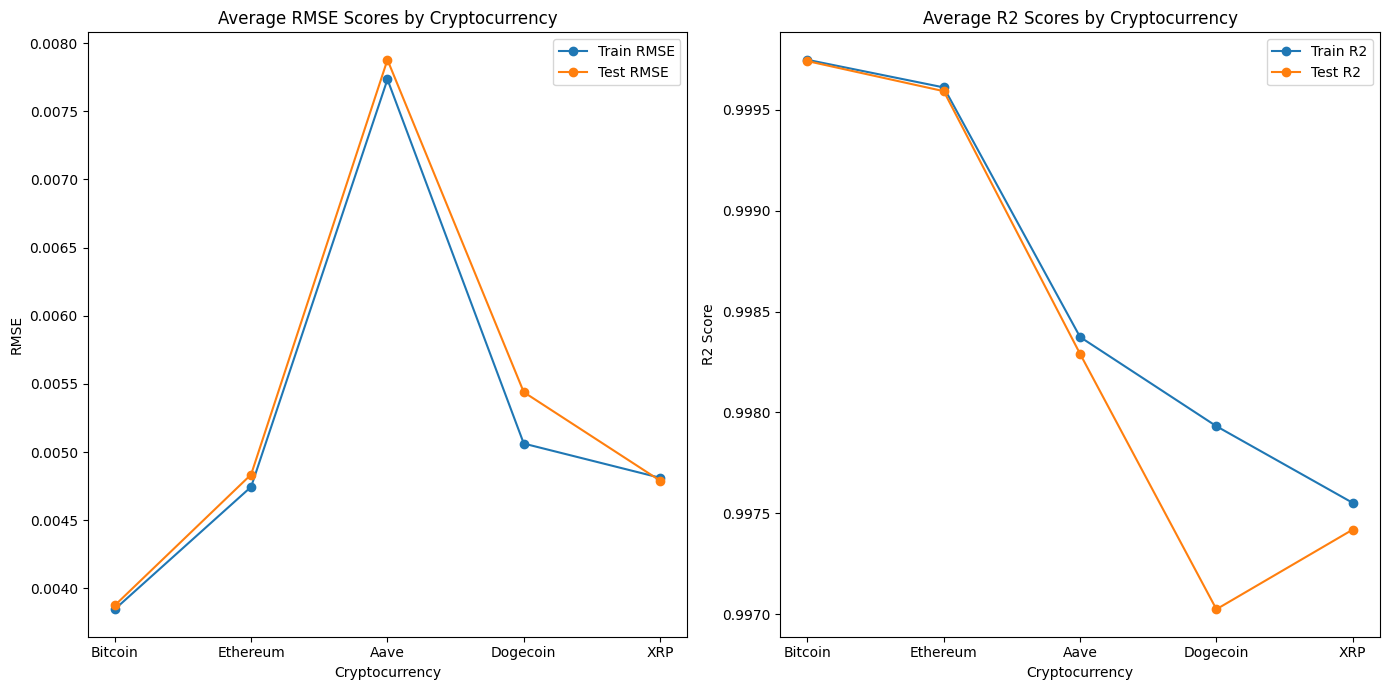

In [44]:
def perform_k_fold_cv(dataframe, n_splits=5, random_state=42):
    X = dataframe.drop('High', axis=1)
    y = dataframe['High']

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    rmse_scores_train = []
    rmse_scores_test = []
    r2_scores_train = []
    r2_scores_test = []

    pipeline = Pipeline([
        ('scaler', MinMaxScaler()),
        ('model', Ridge())
    ])

    param_distributions = {
        'model__alpha': [0.01, 0.1, 1, 10, 100, 1000],
        'model__solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']  # Solvers
    }

    random_search = RandomizedSearchCV(estimator=pipeline, param_distributions=param_distributions,
                                       n_iter=10, cv=3, scoring='neg_mean_squared_error',
                                       verbose=2, random_state=random_state, n_jobs=-1)

    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        random_search.fit(X_train, y_train)
        best_model = random_search.best_estimator_

        y_train_pred = best_model.predict(X_train)
        y_test_pred = best_model.predict(X_test)

        rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
        rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
        rmse_scores_train.append(rmse_train)
        rmse_scores_test.append(rmse_test)

        r2_train = r2_score(y_train, y_train_pred)
        r2_test = r2_score(y_test, y_test_pred)
        r2_scores_train.append(r2_train)
        r2_scores_test.append(r2_test)

    avg_rmse_train = np.mean(rmse_scores_train)
    avg_rmse_test = np.mean(rmse_scores_test)
    avg_r2_train = np.mean(r2_scores_train)
    avg_r2_test = np.mean(r2_scores_test)

    return avg_rmse_train, avg_rmse_test, avg_r2_train, avg_r2_test


results = {}
for crypto, dataset in scaled_coins.items():
    results[crypto] = perform_k_fold_cv(dataset)


df_results = pd.DataFrame(results, index=['avg_rmse_train', 'avg_rmse_test', 'avg_r2_train', 'avg_r2_test']).T

plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
plt.plot(df_results.index, df_results['avg_rmse_train'], label='Train RMSE', marker='o')
plt.plot(df_results.index, df_results['avg_rmse_test'], label='Test RMSE', marker='o')
plt.title('Average RMSE Scores by Cryptocurrency')
plt.ylabel('RMSE')
plt.xlabel('Cryptocurrency')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(df_results.index, df_results['avg_r2_train'], label='Train R2', marker='o')
plt.plot(df_results.index, df_results['avg_r2_test'], label='Test R2', marker='o')
plt.title('Average R2 Scores by Cryptocurrency')
plt.ylabel('R2 Score')
plt.xlabel('Cryptocurrency')
plt.legend()

plt.tight_layout()
plt.show()

In [45]:
print("Average RMSE and R^2 Scores:")
for crypto in df_results.index:
    print(f"{crypto}:")
    print(df_results.loc[crypto])


Average RMSE and R^2 Scores:
Bitcoin:
avg_rmse_train    0.003848
avg_rmse_test     0.003876
avg_r2_train      0.999748
avg_r2_test       0.999742
Name: Bitcoin, dtype: float64
Ethereum:
avg_rmse_train    0.004745
avg_rmse_test     0.004836
avg_r2_train      0.999611
avg_r2_test       0.999593
Name: Ethereum, dtype: float64
Aave:
avg_rmse_train    0.007734
avg_rmse_test     0.007878
avg_r2_train      0.998374
avg_r2_test       0.998290
Name: Aave, dtype: float64
Dogecoin:
avg_rmse_train    0.005063
avg_rmse_test     0.005440
avg_r2_train      0.997932
avg_r2_test       0.997024
Name: Dogecoin, dtype: float64
XRP:
avg_rmse_train    0.004812
avg_rmse_test     0.004791
avg_r2_train      0.997551
avg_r2_test       0.997419
Name: XRP, dtype: float64
